<a href="https://colab.research.google.com/github/vishnuiiit/human-identification/blob/master/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.mkdir('/content/data')
!unzip "/content/drive/My Drive/data/faces.zip" -d "/content/data/faces"

In [ ]:
!unzip "/content/drive/My Drive/data/audio.zip" -d "/content/data"

In [ ]:
!unzip "/content/drive/My Drive/data/subSetFaces.zip" -d "/content/data"

**Data Preprocessing**

In [ ]:
from PIL import Image
import tensorflow as tf
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import csv
import glob
import shutil
import pathlib

class Data:
    def __init__(self, pId, name, gender, nationality):
        self.id = pId
        self.name = name
        self.gender = gender
        self.nationality = nationality


In [ ]:
def getMetaData(path):
    data = {}
    with open(path) as csvFile:
        csv_reader = csv.reader(csvFile, delimiter='\t')
        line = 0
        for row in csv_reader:
            if line != 0:
                data[row[0]] = Data(row[0], row[1], row[2], row[3])
            line += 1

    return data

def getNames(dataDict, parentDir):
    names = []
    subDirs = next(os.walk(parentDir))[1]
    for subDir in subDirs:
        pId = subDir
        names.append([pId, dataDict[pId].name])

    return names

image_raw_data_path = '/content/data/subSetFaces'
audio_data_path = '/content/data/wav'
meta_data_path = '/content/drive/My Drive/data/vox1_meta.csv'
all_data = getMetaData(meta_data_path)
all_names = getNames(all_data, audio_data_path)


In [ ]:
def reset_weights(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model): #if you're using a model as a layer
            reset_weights(layer) #apply function recursively
            continue

        #where are the initializers?
        if hasattr(layer, 'cell'):
            init_container = layer.cell
        else:
            init_container = layer

        for key, initializer in init_container.__dict__.items():
            if "initializer" not in key: #is this item an initializer?
                  continue #if no, skip it

            # find the corresponding variable, like the kernel or the bias
            if key == 'recurrent_initializer': #special case check
                var = getattr(init_container, 'recurrent_kernel')
            else:
                var = getattr(init_container, key.replace("_initializer", ""))

            var.assign(initializer(var.shape, var.dtype))
            #use the initializer

In [ ]:
def getImageData(parentDir, subDirs, imagesPerLabel=100, totalLabels=20, imgDim=(300, 300)):
    images = []
    labels = []
    i = 0
    for subDir in subDirs:
        pDir = os.path.join(parentDir, subDir[1])
        imagesInEachSubDir = []
        for fn in glob.glob(os.path.join(pDir, '1.6/*')):
            imagesInEachSubDir.append(len(glob.glob(os.path.join(fn, '*jpg'))))

        totalImagesFromEachDir = []
        totalImagesInserted = 0

        while totalImagesInserted != imagesPerLabel:
            for j in range(len(imagesInEachSubDir)):
                if totalImagesInserted == imagesPerLabel:
                    break
                if len(totalImagesFromEachDir) < j + 1:
                    totalImagesFromEachDir.append(0)
                if totalImagesFromEachDir[j] < imagesInEachSubDir[j]:
                    totalImagesFromEachDir[j] += 1
                    totalImagesInserted += 1

        j = 0
        imagesInsertedThisLabel = 0
        for subSubDir in glob.glob(os.path.join(pDir, '1.6/*')):
            imagesThisDirInserted = 0
            for fn in glob.glob(os.path.join(subSubDir, '*.jpg')):
                img = Image.open(fn)
                img = img.resize(imgDim)
                img = np.asarray(img)
                images.append(img)
                labels.append(i)
                imagesThisDirInserted += 1
                imagesInsertedThisLabel += 1
                if imagesThisDirInserted == totalImagesFromEachDir[j]:
                    break
            j += 1
        if imagesInsertedThisLabel != imagesPerLabel:
            print(pDir, ' : ', imagesInsertedThisLabel)
            print(imagesInEachSubDir)
            print(totalImagesFromEachDir)
        i += 1
        if i >= totalLabels:
            break
    labels = tf.keras.utils.to_categorical(labels)
    return np.array(images), labels

img_dim = (246, 246)
image_data, image_labels = getImageData(image_raw_data_path, all_names, imagesPerLabel=100, totalLabels=len(all_names), imgDim=img_dim)
print('image data: ', image_data.shape, 'labels: ', image_labels.shape)

image data:  (4000, 246, 246, 3) labels:  (4000, 40)


In [ ]:
img_input_dim = img_dim + (3, )
print(img_input_dim)

(246, 246, 3)


In [ ]:
def getAllData(x, y, testDataSize=0.1):
    testIndex = []
    testX = []
    testY = []
    dataX = []
    dataY = []
    testDataSize = int(len(x) * testDataSize)
    if testDataSize < 0 or testDataSize > len(x):
        raise ValueError('testDataSize should be between 0 and len(x)')
    for i in range(testDataSize):
        temp = random.randint(0, len(x) - 1)
        while temp in testIndex:
            temp = random.randint(0, len(x) - 1)
        testIndex.append(temp)
        testX.append(x[temp])
        testY.append(y[temp])

    testX = np.array(testX)
    testY = np.array(testY)

    for i in range(x.shape[0]):
        if not i in testIndex:
            dataX.append(x[i])
            dataY.append(y[i])

    dataX = np.array(dataX)
    dataY = np.array(dataY)
    return dataX, dataY, testX, testY


**Image Classification Model**

In [ ]:
train_img_data, train_img_labels, val_img_data, val_img_labels = getAllData(image_data, image_labels)
print('training data: ', train_img_data.shape, ' training labels: ', train_img_labels.shape)
print('validation data: ', val_img_data.shape, ' validation labels: ', val_img_labels.shape)

training data:  (3600, 246, 246, 3)  training labels:  (3600, 40)
validation data:  (400, 246, 246, 3)  validation labels:  (400, 40)


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(img_input_dim))
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.MaxPool2D((4, 4)))
# model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal'))
# # model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.MaxPool2D())
# model.add(tf.keras.layers.Conv2D(128, (6, 6), activation='relu', kernel_initializer='he_normal'))
# # model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(len(val_img_labels[0]), activation='softmax'))
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_19 (Rescaling)     (None, 246, 246, 3)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 244, 244, 64)      1792      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 122, 122, 64)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 120, 120, 64)      36928     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 57600)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)              

113/113 [==============================] - 1s 11ms/step - loss: 3.7912 - accuracy: 0.0233
Epoch 1/100
113/113 [==============================] - 4s 34ms/step - loss: 3.7040 - accuracy: 0.0300 - val_loss: 3.6380 - val_accuracy: 0.0675
Epoch 2/100
113/113 [==============================] - 4s 34ms/step - loss: 3.6002 - accuracy: 0.0608 - val_loss: 3.4914 - val_accuracy: 0.1150
Epoch 3/100
113/113 [==============================] - 4s 34ms/step - loss: 3.4312 - accuracy: 0.1139 - val_loss: 3.2906 - val_accuracy: 0.1675
Epoch 4/100
113/113 [==============================] - 4s 34ms/step - loss: 3.1712 - accuracy: 0.1711 - val_loss: 3.0607 - val_accuracy: 0.2325
Epoch 5/100
113/113 [==============================] - 4s 34ms/step - loss: 2.8882 - accuracy: 0.2383 - val_loss: 2.8253 - val_accuracy: 0.2700
Epoch 6/100
113/113 [==============================] - 4s 34ms/step - loss: 2.5891 - accuracy: 0.3017 - val_loss: 2.4738 - val_accuracy: 0.3375
Epoch 7/100
113/113 [=========================

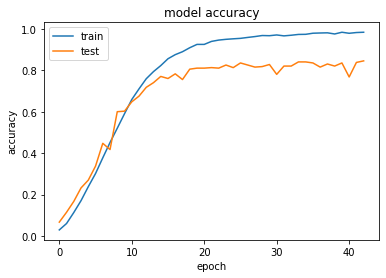

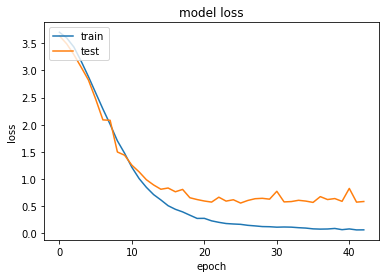

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

reset_weights(model)
model.evaluate(val_img_data, val_img_labels)
model.evaluate(train_img_data, train_img_labels)
history = model.fit(train_img_data, train_img_labels, epochs=100, batch_size=32, validation_data=(val_img_data, val_img_labels), shuffle=True, callbacks=[callback])
model.evaluate(train_img_data, train_img_labels)
model.evaluate(val_img_data, val_img_labels)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Audio Data Preprocessing**

In [ ]:
import librosa
import librosa.display
import keras.utils as ut
import IPython.display as ipd
import skimage.io
import time


def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled


def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += int(window_size / 2)


def getAudioData(parentDir, subDirs, bands=128, audiosPerLabel=100, totalLabels=20):
    window_size = 512 * 127
    data = []
    labels = []
    total_ids = 0
    for subDir in subDirs:
        pDir = os.path.join(parentDir, subDir[0])
        audio_per_person = 0
        for fn in glob.glob(os.path.join(pDir, "*/*.wav")):
            sound_clip, s = librosa.load(fn)
            for (start, end) in windows(sound_clip, window_size):
                if len(sound_clip[start:end]) == window_size:
                    signal = sound_clip[start:end]
                    melspec = librosa.feature.melspectrogram(signal, n_mels=bands)
                    logspec = np.log(melspec + 1e-9)
                    img = scale_minmax(logspec, 0, 255).astype(np.uint8)
                    img = np.flip(img, axis=0)
                    img = 255 - img
                    data.append(img)
                    labels.append(total_ids)
                    audio_per_person += 1
                    # skimage.io.imsave(fn[start:(len(fn) - 4)] + ".png", img)
                    if audio_per_person >= audiosPerLabel:
                        break
            if audio_per_person >= audiosPerLabel:
                break
        print(total_ids, ') ', subDir[0], ' : ', audio_per_person)
        total_ids += 1
        if total_ids >= totalLabels:
            break

    features = np.array(data)
    features = features.reshape((len(data), 128, 128, 1))
    labels = tf.keras.utils.to_categorical(labels)
    return features, labels


audio_data, audio_labels = getAudioData(audio_data_path, all_names, totalLabels=len(all_names))
print(audio_data.shape, audio_labels.shape)

# trainX, trainY, testX, testY = getAllData(data, labels)


0 )  id10279  :  100
1 )  id10285  :  100
2 )  id10276  :  100
3 )  id10299  :  100
4 )  id10288  :  100
5 )  id10283  :  100
6 )  id10286  :  100
7 )  id10305  :  100
8 )  id10274  :  100
9 )  id10296  :  100
10 )  id10291  :  100
11 )  id10281  :  100
12 )  id10287  :  100
13 )  id10301  :  100
14 )  id10293  :  100
15 )  id10292  :  100
16 )  id10277  :  100
17 )  id10275  :  100
18 )  id10308  :  100
19 )  id10278  :  100
20 )  id10289  :  100
21 )  id10272  :  100
22 )  id10303  :  100
23 )  id10302  :  100
24 )  id10280  :  100
25 )  id10271  :  100
26 )  id10307  :  100
27 )  id10295  :  100
28 )  id10273  :  100
29 )  id10309  :  100
30 )  id10300  :  100
31 )  id10298  :  100
32 )  id10297  :  100
33 )  id10282  :  100
34 )  id10290  :  100
35 )  id10294  :  100
36 )  id10284  :  100
37 )  id10306  :  100
38 )  id10304  :  100
39 )  id10270  :  100
(4000, 128, 128, 1) (4000, 40)


In [ ]:
def runModel(model, patience=5):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

    reset_weights(model)
    model.evaluate(testX, testY)
    model.evaluate(trainX, trainY)
    history = model.fit(trainX, trainY, epochs=2000, batch_size=64, validation_data=(testX, testY), shuffle=True, callbacks=[callback])
    model.evaluate(trainX, trainY)
    model.evaluate(testX, testY)

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

**Audio Classification Without LSTM**

In [ ]:
trainX, trainY, testX, testY = getAllData(audio_data, audio_labels)
print("trainX: ", trainX.shape, " trainY: ", trainY.shape, " testX: ", testX.shape, " testY: ", testY.shape)

trainX:  (3600, 128, 128, 1)  trainY:  (3600, 40)  testX:  (400, 128, 128, 1)  testY:  (400, 40)


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input((128, 128, 1)))
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(trainY[0]), activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_22 (Rescaling)     (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 126, 126, 128)     1280      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 57600)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)              

113/113 [==============================] - 2s 14ms/step - loss: 4.3823 - accuracy: 0.0200
Epoch 1/2000
57/57 [==============================] - 4s 69ms/step - loss: 4.2202 - accuracy: 0.0383 - val_loss: 4.1723 - val_accuracy: 0.0575
Epoch 2/2000
57/57 [==============================] - 4s 69ms/step - loss: 4.1539 - accuracy: 0.0556 - val_loss: 4.1518 - val_accuracy: 0.0500
Epoch 3/2000
57/57 [==============================] - 4s 69ms/step - loss: 4.1212 - accuracy: 0.0606 - val_loss: 4.1166 - val_accuracy: 0.0750
Epoch 4/2000
57/57 [==============================] - 4s 69ms/step - loss: 4.0658 - accuracy: 0.0956 - val_loss: 4.0468 - val_accuracy: 0.0625
Epoch 5/2000
57/57 [==============================] - 4s 72ms/step - loss: 3.9741 - accuracy: 0.1208 - val_loss: 3.9835 - val_accuracy: 0.1075
Epoch 6/2000
57/57 [==============================] - 4s 69ms/step - loss: 3.8282 - accuracy: 0.1608 - val_loss: 4.0190 - val_accuracy: 0.0650
Epoch 7/2000
57/57 [==============================] 

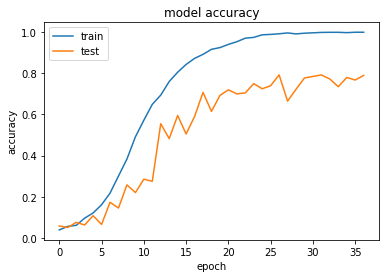

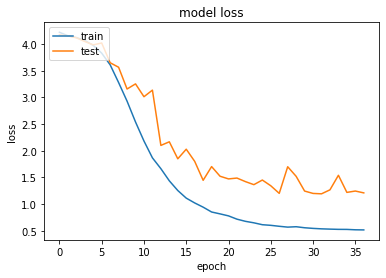

In [ ]:
runModel(model)

**Audio Classification with LSTM**

In [ ]:
audio_data = audio_data.reshape(len(audio_data), 128, 128)
print(audio_data.shape)

(4000, 128, 128)


In [ ]:
trainX, trainY, testX, testY = getAllData(audio_data, audio_labels)
print("trainX: ", trainX.shape, " trainY: ", trainY.shape, " testX: ", testX.shape, " testY: ", testY.shape)

trainX:  (3600, 128, 128)  trainY:  (3600, 40)  testX:  (400, 128, 128)  testY:  (400, 40)


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input((None, 128)))
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
model.add(tf.keras.layers.Conv1D(64, 5, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPool1D())
model.add(tf.keras.layers.Conv1D(128, 5, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPool1D())
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(len(trainY[0]), activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_23 (Rescaling)     (None, None, 128)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 64)          41024     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, None, 64)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 128)         41088     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_25 (Dense)             (None, 64)              

113/113 [==============================] - 0s 4ms/step - loss: 4.2191 - accuracy: 0.0250
Epoch 1/2000
57/57 [==============================] - 0s 8ms/step - loss: 4.2077 - accuracy: 0.0233 - val_loss: 4.2051 - val_accuracy: 0.0175
Epoch 2/2000
57/57 [==============================] - 0s 6ms/step - loss: 4.1997 - accuracy: 0.0258 - val_loss: 4.2005 - val_accuracy: 0.0250
Epoch 3/2000
57/57 [==============================] - 0s 6ms/step - loss: 4.1962 - accuracy: 0.0300 - val_loss: 4.1973 - val_accuracy: 0.0275
Epoch 4/2000
57/57 [==============================] - 0s 6ms/step - loss: 4.1938 - accuracy: 0.0300 - val_loss: 4.1963 - val_accuracy: 0.0225
Epoch 5/2000
57/57 [==============================] - 0s 6ms/step - loss: 4.1914 - accuracy: 0.0253 - val_loss: 4.1925 - val_accuracy: 0.0175
Epoch 6/2000
57/57 [==============================] - 0s 6ms/step - loss: 4.1894 - accuracy: 0.0297 - val_loss: 4.1928 - val_accuracy: 0.0250
Epoch 7/2000
57/57 [==============================] - 0s 6m

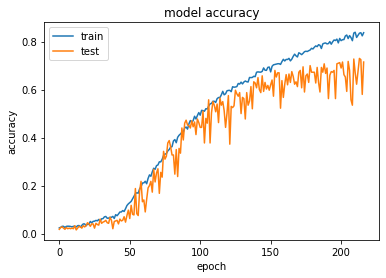

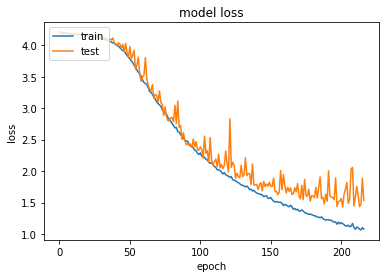

In [ ]:
runModel(model, patience=15)

**Multi Modal Data Preprocessing**

In [ ]:
def labelsTruthValue(labels):
    for i in range(len(labels)):
        if labels[i] == 1:
            return i
    return -1

def fuseAudioImageData(audioData, audioLabels, imageData, imageLabels, sizePerLabel = 0.5):
    if len(audioData) != len(imageData):
        raise ValueError('length of audio and image data should be same')
    if len(audioLabels[0]) != len(imageLabels[0]):
        raise ValueError('length of audio and image labels categories should be same')
    indexes = []
    # trueDataIndexes = set([])
    data = [[], []]
    labels = []
    trueDataSize = int(len(audioData) * sizePerLabel)
    for i in range(len(audioData)):
        indexes.append(i)

    random.shuffle(indexes)
    for index in indexes:
        data[0].append(audioData[index])
        data[1].append(imageData[index])
        labels.append(labelsTruthValue(audioLabels[index]))
        # trueDataIndexes.add(index)
        if len(labels) == trueDataSize:
            break

    # pairInserted = set([])
    # for i in range(trueDataSize):
    #     i1 = random.randint(0, len(audioData) - 1)
    #     i2 = random.randint(0, len(imageData) - 1)
    #     while labelsTruthValue(audioLabels[i1]) == labelsTruthValue(imageLabels[i2]) or (i1, i2) in pairInserted:
    #         i1 = random.randint(0, len(audioData) - 1)
    #         i2 = random.randint(0, len(imageData) - 1)
    #     data[0].append(audioData[i1])
    #     data[1].append(imageData[i1])
    #     labels.append(0)
    #     pairInserted.add((i1, i2))

    return np.array(data), np.array(labels)

In [ ]:
main_data, main_labels = fuseAudioImageData(audio_data, audio_labels, image_data, image_labels, sizePerLabel=1)
print(main_data.shape, main_labels.shape)

(2, 4000) (4000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
def getAllMultiInputData(x, y, testSize = 0.1):
    trainX = []
    trainY = []
    testX = []
    testY = []
    for i in range(len(x)):
        trainX.append([])
        testX.append([])
    
    indexes = []
    for i in range(x.shape[1]):
        indexes.append(i)
    
    random.shuffle(indexes)
    lastIndex = 0
    for i in range(int(x.shape[1] * testSize)):
        lastIndex = i + 1
        for j in range(len(x)):
            testX[j].append(x[j][i])
        testY.append(y[i])

    for i in range(lastIndex, int(x.shape[1])):
        for j in range(len(x)):
            trainX[j].append(x[j][i])
        trainY.append(y[i])
    
    for j in range(len(x)):
        trainX[j] = np.array(trainX[j])
        testX[j] = np.array(testX[j])
    trainY = tf.keras.utils.to_categorical(trainY)
    testY = tf.keras.utils.to_categorical(testY)
    
    return trainX, trainY, testX, testY

In [ ]:
trainX, trainY, testX, testY = getAllMultiInputData(main_data, main_labels)
print(len(trainX), trainX[0].shape, trainX[1].shape, trainY.shape, len(testX), testX[0].shape, testX[1].shape, testY.shape)

2 (3600, 128, 128, 1) (3600, 246, 246, 3) (3600, 40) 2 (400, 128, 128, 1) (400, 246, 246, 3) (400, 40)


**Multi Modal Model**

In [ ]:
def imageExtractFeatures(inputDim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(inputDim))
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    # model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    # model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.MaxPool2D(4, 4))
    model.add(tf.keras.layers.Flatten())
    # model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal'))
    # model.add(tf.keras.layers.Dropout(0.5))
    # model.add(tf.keras.layers.MaxPool2D())
    # model.add(tf.keras.layers.Conv2D(128, (6, 6), activation='relu', kernel_initializer='he_normal'))
    # model.add(tf.keras.layers.Dropout(0.5))
    # model.add(tf.keras.layers.Dense(64, activation='relu'))
    print("image mode:-")
    model.summary()
    return model, model.output_shape


def audioExtractFeatures(inputDim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(inputDim))
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    # model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Flatten())
    print("audio model:-")
    model.summary()
    return model, model.output_shape

def audioExtractFeaturesLSTM(inputDim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(inputDim))
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
    model.add(tf.keras.layers.Conv1D(64, 5, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.MaxPool1D())
    model.add(tf.keras.layers.Conv1D(128, 5, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.MaxPool1D())
    model.add(tf.keras.layers.LSTM(64))
    print("audio model:-")
    model.summary()
    return model, model.output_shape


def getFusionModel(inputShape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(inputShape))
    # model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal'))
    # model.add(tf.keras.layers.MaxPool2D())
    # model.add(tf.keras.layers.Flatten())
    # model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.Dropout(0.15))
    # model.add(tf.keras.layers.Dense(2, activation='softmax', kernel_initializer='glorot_normal'))
    print("fused model:-")
    model.summary()
    return model


def getModel():
    img_feat_model, img_output_shape = imageExtractFeatures(img_input_dim)
    audio_feat_model, audio_output_shape = audioExtractFeatures((128, 128, 1))
    img_input = tf.keras.Input(img_input_dim)
    audio_input = tf.keras.Input((128, 128, 1))
    imgFeat = img_feat_model(img_input)
    audioFeat = audio_feat_model(audio_input)

    concat = tf.keras.layers.Concatenate()([audioFeat, imgFeat])
    print(img_output_shape, audio_output_shape)
    fusionModel = getFusionModel((img_output_shape[1] + audio_output_shape[1]))
    fusedModelTensor = fusionModel(concat)
    softmaxLayer = tf.keras.layers.Dense(40, activation='softmax', kernel_initializer='he_normal')(fusedModelTensor)
    model = tf.keras.Model(inputs=[audio_input, img_input], outputs=softmaxLayer)
    return model


**Multi Modal with LSTM in audio classification Results**

In [ ]:
model = getModel()
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

image mode:-
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_12 (Rescaling)     (None, 246, 246, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 244, 244, 64)      1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 122, 122, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 120, 120, 64)      36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64) 

113/113 [==============================] - 2s 19ms/step - loss: 4.5635 - accuracy: 0.0228
Epoch 1/2000
57/57 [==============================] - 9s 131ms/step - loss: 4.6204 - accuracy: 0.0397 - val_loss: 4.0465 - val_accuracy: 0.1000
Epoch 2/2000
57/57 [==============================] - 7s 130ms/step - loss: 3.6844 - accuracy: 0.1464 - val_loss: 3.2083 - val_accuracy: 0.2475
Epoch 3/2000
57/57 [==============================] - 8s 132ms/step - loss: 2.7407 - accuracy: 0.3525 - val_loss: 2.1991 - val_accuracy: 0.4925
Epoch 4/2000
57/57 [==============================] - 7s 131ms/step - loss: 1.9062 - accuracy: 0.5436 - val_loss: 1.6687 - val_accuracy: 0.6300
Epoch 5/2000
57/57 [==============================] - 7s 130ms/step - loss: 1.3747 - accuracy: 0.6775 - val_loss: 1.4417 - val_accuracy: 0.6775
Epoch 6/2000
57/57 [==============================] - 7s 129ms/step - loss: 1.0088 - accuracy: 0.7742 - val_loss: 1.2494 - val_accuracy: 0.7225
Epoch 7/2000
57/57 [==========================

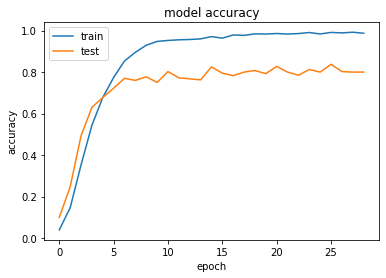

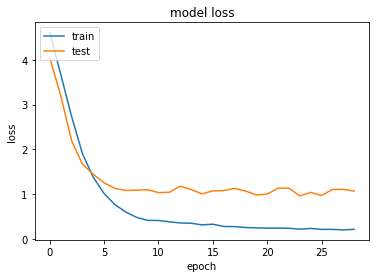

In [ ]:
runModel(model)

**Multi Modal without LSTM in audio classification Results**

In [ ]:
model = getModel()
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

image mode:-
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_18 (Rescaling)     (None, 246, 246, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 244, 244, 64)      1792      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 122, 122, 64)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 120, 120, 64)      36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 57600)             0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
____________________________________

113/113 [==============================] - 3s 30ms/step - loss: 4.5932 - accuracy: 0.0200
Epoch 1/2000
57/57 [==============================] - 11s 189ms/step - loss: 5.2098 - accuracy: 0.0400 - val_loss: 4.2225 - val_accuracy: 0.0550
Epoch 2/2000
57/57 [==============================] - 11s 191ms/step - loss: 3.9526 - accuracy: 0.1142 - val_loss: 3.5674 - val_accuracy: 0.2475
Epoch 3/2000
57/57 [==============================] - 11s 194ms/step - loss: 3.1273 - accuracy: 0.3042 - val_loss: 2.7655 - val_accuracy: 0.4400
Epoch 4/2000
57/57 [==============================] - 11s 192ms/step - loss: 2.3311 - accuracy: 0.5303 - val_loss: 2.1605 - val_accuracy: 0.5950
Epoch 5/2000
57/57 [==============================] - 11s 191ms/step - loss: 1.8518 - accuracy: 0.6519 - val_loss: 2.0150 - val_accuracy: 0.6175
Epoch 6/2000
57/57 [==============================] - 11s 190ms/step - loss: 1.5132 - accuracy: 0.7422 - val_loss: 1.9189 - val_accuracy: 0.6625
Epoch 7/2000
57/57 [====================

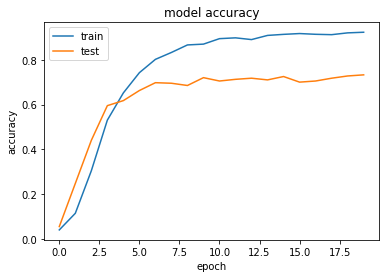

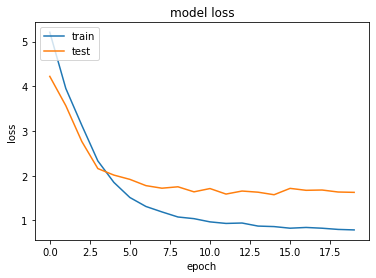

In [ ]:
runModel(model)